import CNN models
import map-based data

loop over number of data samples
    apply CNN model to data
    de-normalize
    calculate NMSE


In [10]:
import h5py
import torch
import torch.nn as nn
import random


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
from scipy.io import savemat
from torch.utils.data import DataLoader, TensorDataset

sys.path.append('../helper')
from utils import CNN_Est
import loader


### Load min, max variables for normalize and denormalize 

In [12]:
rowss = '1500_1509_3916_3920'
save_path = '../model/static/CNN/BS16/'+ rowss + '/ver2/'
SNR = np.arange(0, 31, 5) # 0:5:30 dB
device = 'cpu'
BATCH_SIZE = 32

average_nmse_LS_LI = []
average_nmse_LI_NN = []
average_nmse_LS_NN = []


for snr in SNR:
    variables = torch.load(save_path + str(snr) + 'dB/CNN_1_variable.pth')

    trainData_LS_min = variables['train_min_LS']
    trainData_LS_max = variables['train_max_LS']
    trainData_LI_min = variables['train_min_LI']
    trainData_LI_max = variables['train_min_LI']
    trainLabels_min  = variables['train_label_min']
    trainLabels_max  = variables['train_label_max']

    model_LS_CNN = CNN_Est()
    checkpoint_LS = torch.load(save_path + str(snr) + 'dB/CNN_1_LS_CNN_model.pth')
    model_LS_CNN.load_state_dict(checkpoint_LS['model_state_dict'])
    model_LS_CNN.eval()

    model_LS_LI_CNN = CNN_Est()
    checkpoint_LI = torch.load(save_path + str(snr) + 'dB/CNN_1_LS_CNN_model.pth')
    model_LS_LI_CNN.load_state_dict(checkpoint_LI['model_state_dict'])
    model_LS_LI_CNN.eval()

    mapBaseData_path = '../../CDL Customization/Data/ver1/' + str(snr) + 'dB/1_mapBaseData.mat'
    file = h5py.File(mapBaseData_path, 'r')
    file['H_data'].shape

    H_true = np.empty((0, 2, 612, 14)) # true channel
    H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
    H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
            
    H_true = np.concatenate((H_true, np.transpose(np.array(file['H_data']), (0,1,3,2))) , axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, np.transpose(np.array(file['H_equalized_data']), (0,1,3,2))), axis = 0)
    H_linear = np.concatenate((H_linear, np.transpose(np.array(file['H_linear_data']), (0,1,3,2))), axis=0)

    H_true = torch.from_numpy(H_true)
    H_equal = torch.from_numpy(H_equal)
    H_linear = torch.from_numpy(H_linear)


    testData_LS_normd   = (H_equal - trainData_LS_min)/ (trainData_LS_max - trainData_LS_min)
    testData_LI_normd   = (H_linear - trainData_LI_min)/ (trainData_LI_max - trainData_LI_min)

    testData_LS_normd = testData_LS_normd.to(device, dtype=torch.float)
    testData_LI_normd = testData_LI_normd.to(device, dtype=torch.float)
    H_true = H_true.to(device, dtype=torch.float)

    # Create a DataLoader for dataset
    test_dataset = TensorDataset(testData_LS_normd, testData_LI_normd, H_true)  # [nSamples, 2, 612, 14]
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


    with torch.no_grad():
        nmse_LS_LI = []
        nmse_LS_NN = []
        nmse_LI_NN = []
        print(f"SNR: {snr}/{SNR[-1]}")
        for batch_idx, (LS_inputs, LI_inputs, test_targets) in enumerate(test_loader):
            # LS_inputs == channel after LS, after normalized
            # LI_inputs == channel after LS+LI, after normalized
            # test_targets == true channel
            if (batch_idx + 1)%5==0:
                print(f" - Batch {batch_idx + 1}/{len(test_loader)}")
            
            LS_inputs_real = LS_inputs[:,0,:,:].unsqueeze(1)
            LS_inputs_imag = LS_inputs[:,1,:,:].unsqueeze(1)
            
            LI_inputs_real = LI_inputs[:,0,:,:].unsqueeze(1)
            LI_inputs_imag = LI_inputs[:,1,:,:].unsqueeze(1)
            
            # Calculate the variance of the targets
            test_targets_complex = torch.complex(test_targets[:,0,:,:], test_targets[:,1,:,:])
            variance = torch.var(test_targets_complex)
            
            # NMSE of LS+NN
            LS_outputs_real = model_LS_CNN(LS_inputs_real) # 32x1x612x14
            LS_outputs_imag = model_LS_CNN(LS_inputs_imag) 
            LS_outputs = torch.cat((LS_outputs_real, LS_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LS_outputs_denormd = LS_outputs * (trainLabels_max - trainLabels_min) + trainLabels_min
            LS_outputs_complex = torch.complex(LS_outputs_real, LS_outputs_imag)
            # Calculate the mean squared error
            mse_LS_NN = torch.mean(torch.abs(test_targets_complex - LS_outputs_complex) ** 2)
            nmse_LS_NN.append(mse_LS_NN / variance)
            
            # NMSE of LS+LI
            # De-normalized --> return H_linear back 
            LS_LI_outputs_denormd = LI_inputs * (trainLabels_max - trainLabels_min) + trainLabels_min
            LS_LI_outputs_complex = torch.complex(LI_inputs[:,0,:,:], LI_inputs[:,1,:,:])
            # Calculate the mean squared error
            mse_LS_LI = torch.mean(torch.abs(test_targets_complex - LS_LI_outputs_complex) ** 2)
            nmse_LS_LI.append(mse_LS_LI / variance)
            
            # NMSE of LS+LI+NN
            LI_NN_outputs_real = model_LS_LI_CNN(LI_inputs_real)    # 32x1x612x14
            LI_NN_outputs_imag = model_LS_LI_CNN(LI_inputs_imag)
            LI_NN_outputs = torch.cat((LI_NN_outputs_real, LI_NN_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LI_NN_outputs_denormd = LI_NN_outputs * (trainLabels_max - trainLabels_min) + trainLabels_min
            LI_NN_outputs_complex = torch.complex(LI_NN_outputs_real, LI_NN_outputs_imag)
            # Calculate the mean squared error
            mse_LI_NN = torch.mean(torch.abs(test_targets_complex - LI_NN_outputs_complex) ** 2)
            nmse_LI_NN.append(mse_LI_NN / variance)
            
        average_nmse_LS_LI.append(sum(nmse_LS_LI)/len(nmse_LS_LI))
        average_nmse_LS_NN.append(sum(nmse_LS_NN)/len(nmse_LS_NN))
        average_nmse_LI_NN.append(sum(nmse_LI_NN)/len(nmse_LI_NN))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 612 and the array at index 1 has size 14

# Results

## True Channel

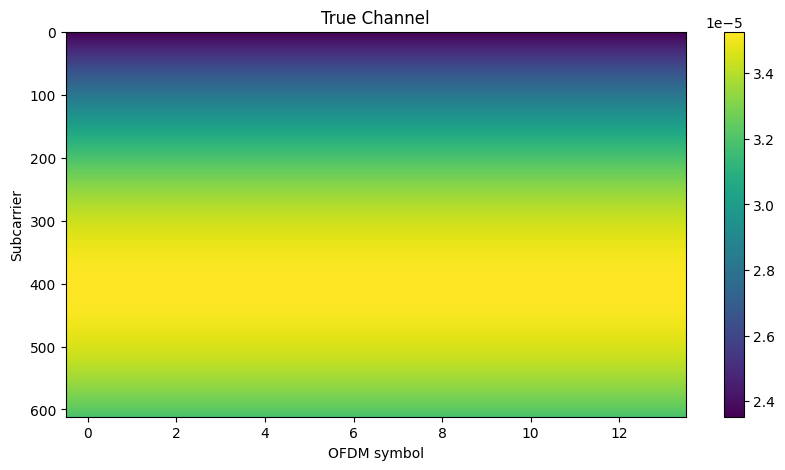

In [ ]:

plt.figure(figsize=(10, 5))
plt.imshow(H_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('True Channel')
plt.colorbar()
plt.show()

## Just LS

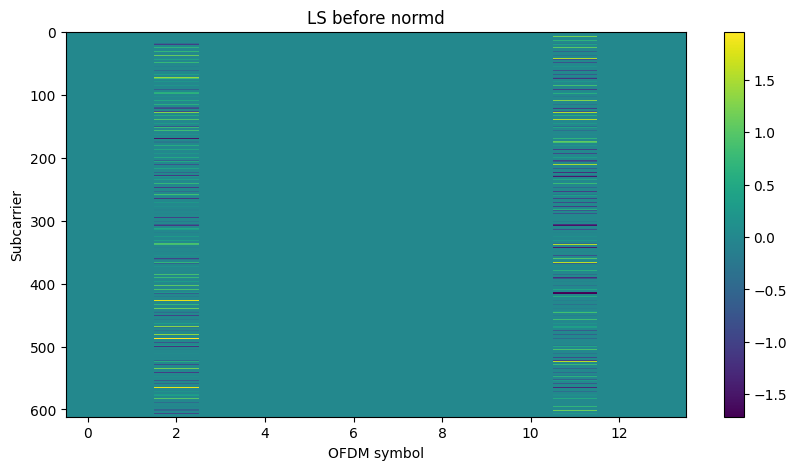

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(H_equal[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS before normd')
plt.colorbar()
plt.show()

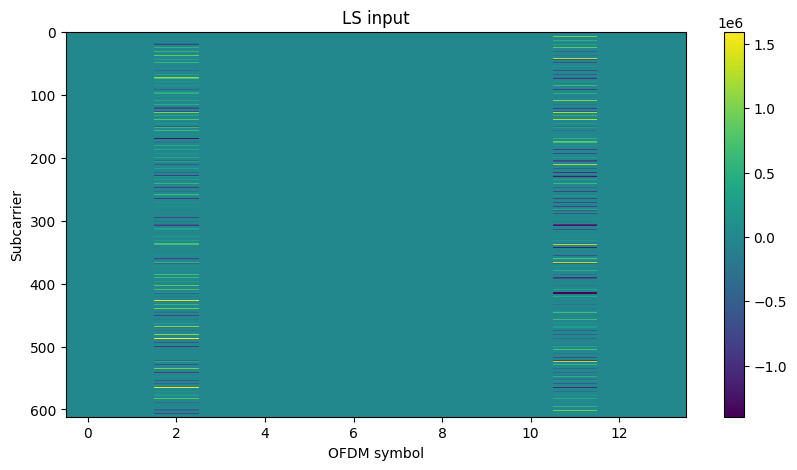

In [ ]:

plt.figure(figsize=(10, 5))
plt.imshow(LS_inputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS input (LS normd)')
plt.colorbar()
plt.show()

## LS + CNN

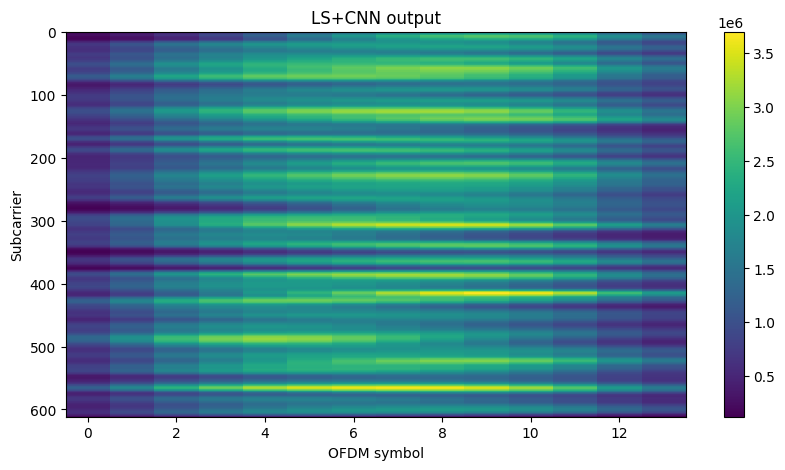

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(LS_outputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+CNN output')
plt.colorbar()
plt.show()

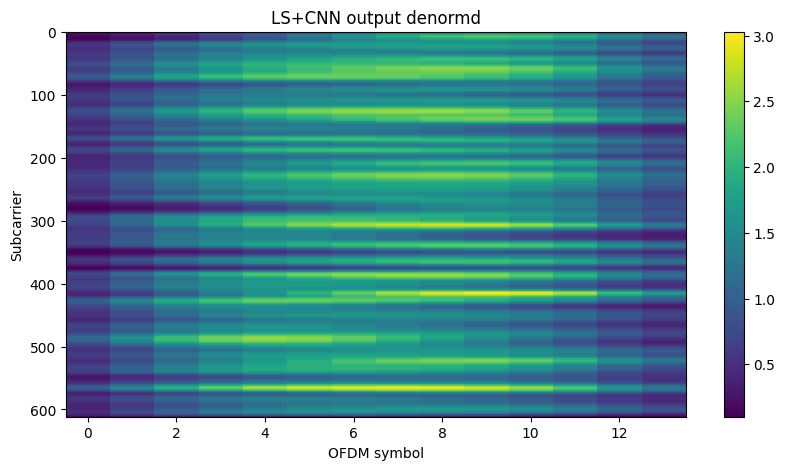

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(LS_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+CNN output denormd')
plt.colorbar()
plt.show()

## LS+LI

Just need to use H_linear straight

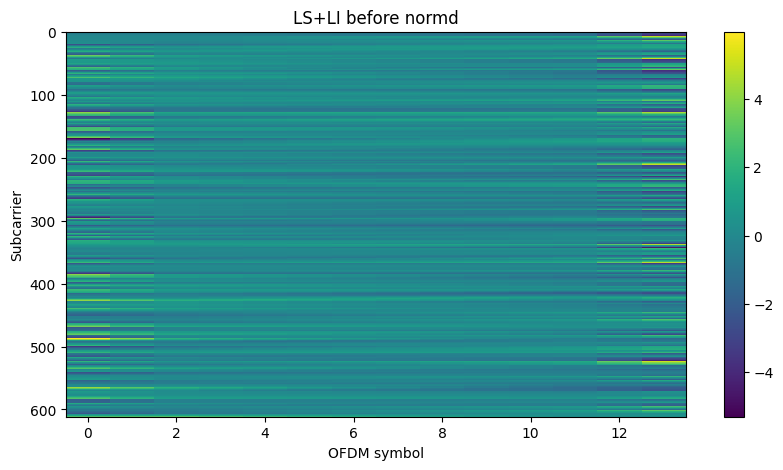

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(H_linear[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI before normd')
plt.colorbar()
plt.show()

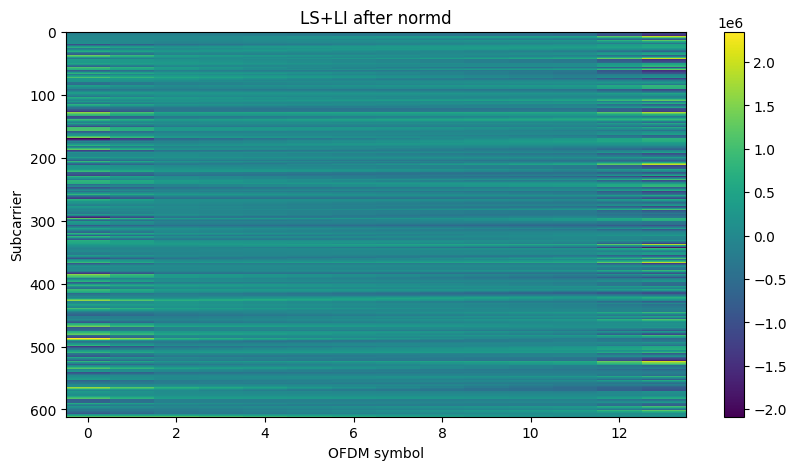

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(LI_inputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI after normd')
plt.colorbar()
plt.show()

## LS+LI+CNN

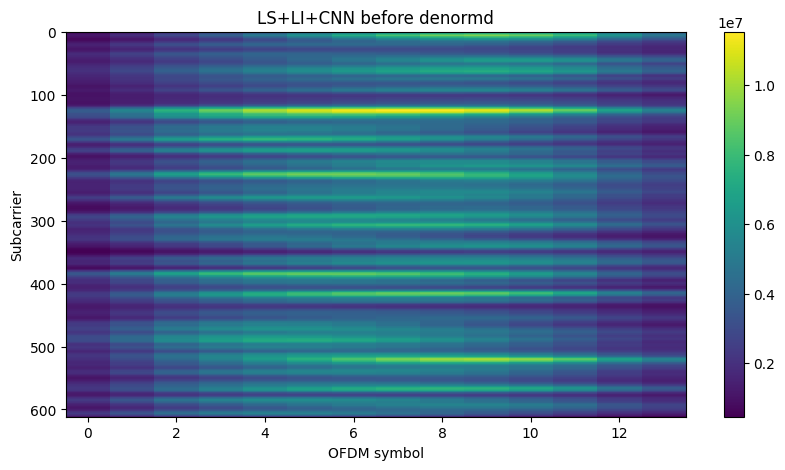

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(	LI_NN_outputs_real[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI+CNN before denormd')
plt.colorbar()
plt.show()

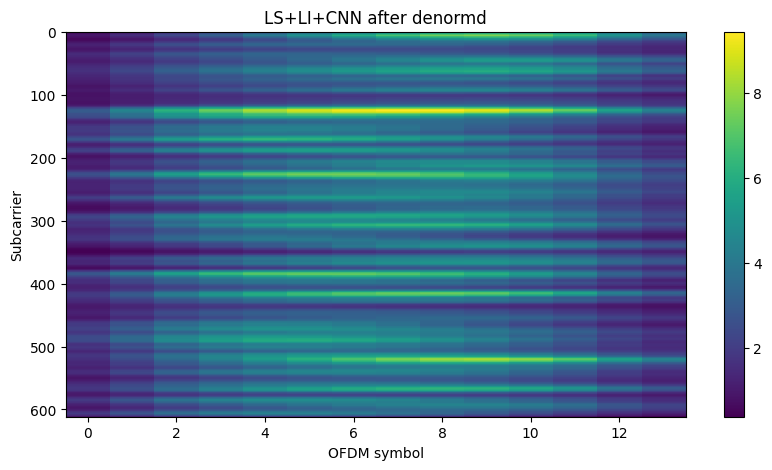

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(	LI_NN_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI+CNN after denormd')
plt.colorbar()
plt.show()

## NMSE

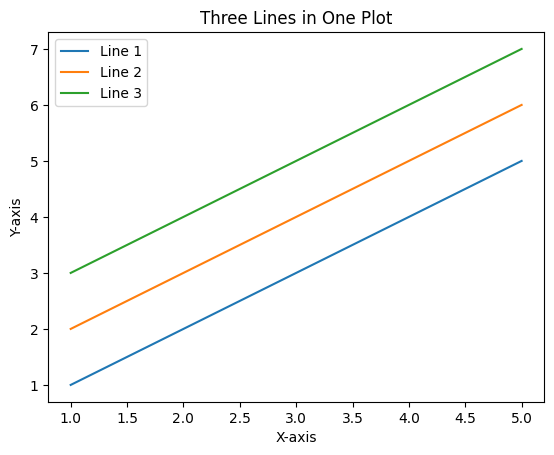

In [ ]:
x = [1, 2, 3, 4, 5]
y1 = [1, 2, 3, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [3, 4, 5, 6, 7]

# Plot each line
plt.plot(x, y1, label='Line 1')
plt.plot(x, y2, label='Line 2')
plt.plot(x, y3, label='Line 3')

# Add title and labels
plt.title("Three Lines in One Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.show()

In [5]:
average_nmse_LS_LI

[tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan)]

In [6]:
average_nmse_LS_NN

[tensor(1.5360e+22),
 tensor(5.1507e+21),
 tensor(1.7171e+21),
 tensor(1.6445e+20),
 tensor(5.6037e+20),
 tensor(3.9535e+19),
 tensor(3.8994e+18)]

In [7]:
average_nmse_LI_NN

[tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan)]

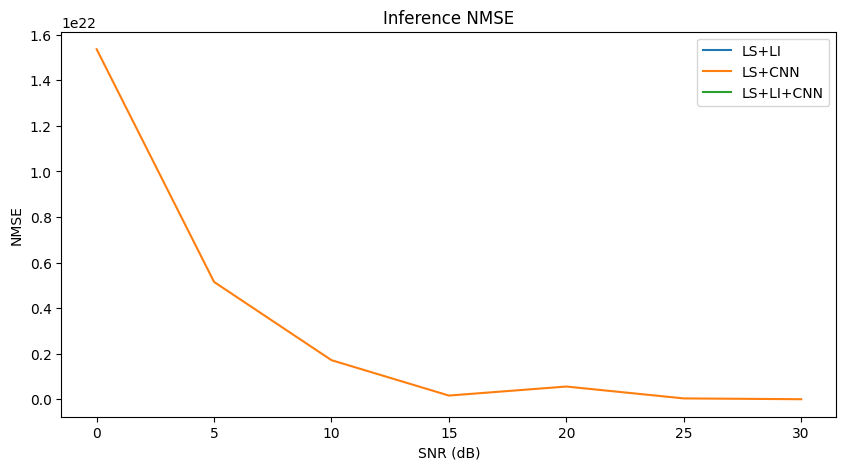

In [9]:
x = [i * 5 for i in range(len(average_nmse_LS_LI))]

plt.figure(figsize=(10, 5))
plt.plot(x, average_nmse_LS_LI, label = 'LS+LI')
plt.plot(x, average_nmse_LS_NN, label = 'LS+CNN')
plt.plot(x, average_nmse_LI_NN, label = 'LS+LI+CNN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Inference NMSE')
plt.legend()
plt.show()